# PNEUMONIA DETECTION FROM X-RAY IMAGES
### COUDERC Alexis, NICOLAS Maelle


Before taking a look at our code, please run the cell below to import all the used library. You can also download our database on this Google Drive (1.3 Go).
https://drive.google.com/drive/folders/1QcJlN-PSJmaDTwYe1sqjVy0Q6hsKE-PK?usp=sharing

In [1]:
from PIL import Image
import numpy as np
import os
import random
from scipy import signal
import scipy
from scipy.stats import logistic
from NeuralNetwork import MLP
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn import datasets
from math import floor
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from keras.models import Sequential
import tensorflow as tf
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import ConvergenceWarning

# 1) LOADING AND PREPARING THE DATASET

## 1.1) Loading and resizing the images

We have more than 2800 X-RAY images of  chests, classified as NORMAL or PNEUMONIA. We use the os library to load the images. As there are approximately 1300x1000 pixels we decided to resize them in 32x32 to diminish the time of execution of our algorithm. Some images were not in black and white we had to convert them. Then, we transform the picture in an array. Each element of the array represents a pixel by a number between 0 (black) and 255 (white). Finally, we normalize our input by dividing every coefficient by 255; and we reshape our matrix as a single line of coefficient belonging to [0,1].

The final array representation of the image : [[0.09019608 0.25098039 0.35686275 ... 0.14117647 0.17254902 0.18823529]]


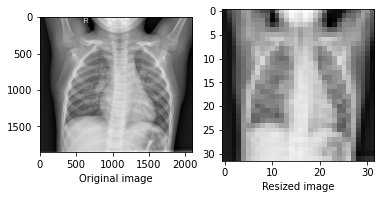

In [2]:
resize = 32,32
reshape = resize[0]*resize[1]


for filename in os.listdir('chest_xray/data/NORMAL'):
    im = Image.open('chest_xray/data/NORMAL/'+filename)
    im =im.convert('L') #if the picture is not in black and white, we convert it
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(np.asarray(im), cmap='gray')
    ax1.set_xlabel("Original image")
   
    im= im.resize(resize) #resize the picture
    pix = np.asarray(im)
   
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(pix, cmap='gray')
    ax2.set_xlabel('Resized image')
    pix=(pix.reshape(1,reshape))/255
    print("The final array representation of the image :", pix)
    break

## 1.2) Cropping Algorithm
As we can see above, the "resize" operation implies some distortion of the picture as we force it to become a square. Moreover, if we take a look at the data, all the images are not framed in the same way. Some of them have a black margin on the right, on the left or on the upper side, between the face and the arms. But some of them don't. These informations are not useful and might disturb our algorithm so we managed to create an algorithm to crop and uniformize these images. 

The algorithm is quite simple : it runs every line/column starting from a side. If there is a certain number of consecutive pixels that are black (i.e pixel <70), the algorithm adds 1 to the count of lines/columns that should be erased and goes to the next line to check. The algorithm stops when the condition above is not found and crops the image. We applied this algorithm to all the images to create the data_cropped folder containing all the cropped images.


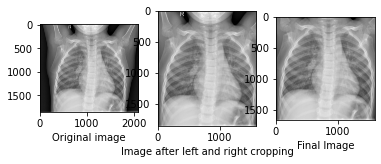

In [4]:
for filename in os.listdir('chest_xray/data/NORMAL'):
    im = Image.open('chest_xray/data/NORMAL/'+filename)
    pix = np.asarray(im)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(np.asarray(im), cmap='gray')
    ax1.set_xlabel("Original image")
    
    
    shape = pix.shape
    count_left, count_right, count_up = 0, 0, 0
    noir=70 #the level of tolerance to black
    number_of_consecutive_black_pixel = floor(shape[0]/10) #if a line has more than this number of consecutive black pixel, 
                                                            #it will be deleted
    
    # find how much to crop on the left side
    k=0
    i=0
    while ((k <shape[1]-number_of_consecutive_black_pixel) and (i < shape[0]-number_of_consecutive_black_pixel)):
        bool = True
        for j in range (0,number_of_consecutive_black_pixel) : 
            if (pix[i+j][k] >= noir):
                bool = False
                break
        if (bool) :
            count_left += 1
            i=0
            k=k+1
        else :
            i=i+1

   
    # find how much to crop on the right side
    k=shape[1]-1
    i=0
    while ((k > number_of_consecutive_black_pixel) and (i < shape[0]-number_of_consecutive_black_pixel)):
        bool = True
        for j in range (0, number_of_consecutive_black_pixel) : 
            if (pix[i+j][k] >= noir):
                bool = False
                break
        if (bool) :
            count_right += 1
            i=0
            k=k-1
        else :
            i=i+1

    #crop on the left and right side
    im1 = im.crop((count_left, 0, shape[1]-count_right, shape[0]))
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(np.asarray(im1), cmap='gray')
    ax2.set_xlabel("Image after left and right cropping")
    
    # find how much to crop on the upper side
    pix = np.asarray(im1)
    shape= pix.shape
    number_of_consecutive_black_pixel = floor(shape[1]/10)
    i=0
    k=0
    while ((k < shape[1]-number_of_consecutive_black_pixel) and (i < shape[0]-number_of_consecutive_black_pixel)):
        bool = True
        for j in range (0,number_of_consecutive_black_pixel) : 
            if (pix[i][k+j] >= noir):
                bool = False
                break
        if (bool) :
            count_up += 1
            k=0
            i=i+1
        else :
            k=k+1
    
    #crop the upper side
    im2 = im1.crop((0,count_up,shape[1],shape[0]))
    #then we saved im2
    ax2 = fig.add_subplot(1,3,3)
    ax2.imshow(np.asarray(im2), cmap='gray')
    ax2.set_xlabel("Final Image")
    
    break
    
    
        
            
    
    


## 1.3) Correct the brightness
In order to reduce the differences between the images of our database, we implemented an algorithm to correct the brightness of each picture. This algorithm stretches all the pixels to ensure that the darkest pixel is of value 0 and the brightest of value 255. Unfortunately, applying this algorithm reduced our testing accuracy by 2% : we decided not to use it.

Value of the first pixel before brightness : 88
Value of the first pixel after brightness : 89.40239043824701


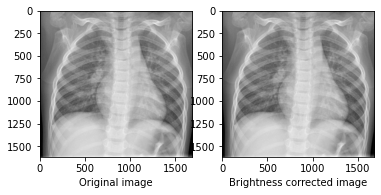

In [5]:
def brightness(pix) :
    minimum = int(pix.min())
    max_pix = int(int(pix.max()) + minimum)
    if (max_pix != 0) :
        pix = (pix-minimum)*(255/max_pix)
    return np.asarray(pix)

for filename in os.listdir('chest_xray/data_cropped/NORMAL'):
    im = Image.open('chest_xray/data_cropped/NORMAL/'+filename)
    pix=np.asarray(im)
    print("Value of the first pixel before brightness :",pix[0][0])
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(pix, cmap='gray')
    ax1.set_xlabel("Original image")
   
    pix = brightness(pix)
    print("Value of the first pixel after brightness :",pix[0][0])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(pix, cmap='gray')
    ax2.set_xlabel('Brightness corrected image')
    break


## 1.4) Convolute the images

We tried to use two filters on our images, one filter improving the outlines, the other the sharpness. Using them has not improved our testing accuracy as you will see in the next part of the code.

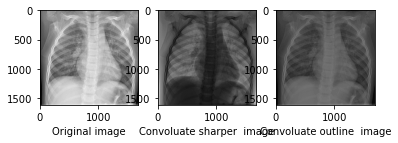

In [6]:
H1=np.array([[-1,-1,-1],[-1,5,-1],[-1,-1,-1]])
H2=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

def convoluate(filter,img) :
    return(scipy.signal.convolve2d(img,filter,mode='same'))

for filename in os.listdir('chest_xray/data_cropped/NORMAL'):
    im = Image.open('chest_xray/data_cropped/NORMAL/'+filename)
    im =im.convert('L') #if the picture is not in black and white, we convert it
    #im= im.resize((32,32)) #resize the picture
    pix=np.asarray(im)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(pix, cmap='gray')
    ax1.set_xlabel("Original image")
   
    pix1=convoluate(H1,pix)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(pix1, cmap='gray')
    ax2.set_xlabel('Convoluate sharper  image')
    
    pix2=convoluate(H2,pix)
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(pix2, cmap='gray')
    ax3.set_xlabel('Convoluate outline  image')
   
    break

## 1.5) Create our x_train, y_train, x_test and y_test

For each image, we create a tuple [pix, label] that we add to the list D. The label is 0 for normal images, and 1 for pneumonia images. We paid attention to have the same number of pneumonia and normal images because a bigger proportion of a class could affect our results. We proceed the same way for every picture of our database and we randomly shuffle our database D. Then we divided D in 4 lists to create our data. The first 90% of D will be used to create x_train and y_train. The last 10% to create x_test and y_test. In the code below, we also generated data with convolution filters and brightness correction to compare the testing accuracy later.

In [7]:
resize = 32,32
reshape = resize[0]*resize[1]

D=[]

for filename in os.listdir('chest_xray/data_cropped/NORMAL'):
    im = Image.open('chest_xray/data_cropped/NORMAL/'+filename)
    #im =im.convert('L')
    im= im.resize(resize)
    pix = np.asarray(im)
    conv1 = convoluate(H1,pix) #convolution avec H1
    conv2 = convoluate(H2,pix) #convolution avec H2
    br = brightness(pix) #brightness correction


    pix=(pix.reshape(1,reshape))/255
    conv1=(conv1.reshape(1,reshape))/255
    conv2=(conv2.reshape(1,reshape))/255
    br=(br.reshape(1,reshape))/255

    D.append([[pix,conv1,conv2,br],0]) 

NORMAL_SIZE = len(D)


for filename in os.listdir('chest_xray/data_cropped/PNEUMONIA'):
    im = Image.open('chest_xray/data_cropped/PNEUMONIA/'+filename)
    #im =im.convert('L')
    im= im.resize(resize)
    pix = np.asarray(im)
    conv1 = convoluate(H1,pix) #convolution avec H1
    conv2 = convoluate(H2,pix) #convolution avec H2
    br  = brightness(pix) #brightness correction


    pix=(pix.reshape(1,reshape))/255
    conv1=(conv1.reshape(1,reshape))/255
    conv2=(conv2.reshape(1,reshape))/255
    br =(br.reshape(1,reshape))/255

    D.append([[pix,conv1,conv2,br],1]) 

PNEUMONIA_SIZE = len(D)-NORMAL_SIZE


#We take care to have the same number of normal and pneumonia images
if (PNEUMONIA_SIZE >= NORMAL_SIZE):
    D= D[:(2*NORMAL_SIZE)]
else :
    D=D[(len(D)-2*PNEUMONIA_SIZE):]

#We randomly shuffle D and create x_train, y_train, x_test and y_test
random.shuffle(D)
ninety_percent = floor(len(D)*0.9)
count=0  
x_train, y_train, x_test, y_test =[],[],[],[] #normal output
x_train_c1, x_test_c1 =[],[] #convolution with H1 output
x_train_c2, x_test_c2 =[],[] #convolution with H2 output
x_train_br, x_test_br =[],[] #brightness correction output

for k in D :
    if count < ninety_percent :
        x_train.append(k[0][0][0])
        x_train_c1.append(k[0][1][0])
        x_train_c2.append(k[0][2][0])
        x_train_br.append(k[0][3][0])
        y_train.append(k[1]) #they all have the same y_train
    else :
        x_test.append(k[0][0][0])
        x_test_c1.append(k[0][1][0])
        x_test_c2.append(k[0][2][0])
        x_test_br.append(k[0][3][0])
        y_test.append(k[1]) #they all have the same y_test
    count=count+1

x_train=np.array(x_train)
x_train_c1=np.array(x_train_c1)
x_train_c2=np.array(x_train_c2)
x_train_br=np.array(x_train_br)

y_train=np.array(y_train)

x_test=np.array(x_test)
x_test_c1=np.array(x_test_c1)
x_test_c2=np.array(x_test_c2)
x_test_br=np.array(x_test_br)

y_test=np.array(y_test)


print("***Dataset presentation******")
print("number of training images: ", len(x_train))
print("number of testing images : ", len(x_test))

***Dataset presentation******
number of training images:  2318
number of testing images :  258


# 2) FINDING THE BEST MODEL - MODEL SELECTION
Now that we have our data ready to be used, we have to find the best model to predict if a patient has pneumonia.

## 2.1) Multilayer Perceptron (MLP)
The first model we tried to use is the multilayer perceptron.

**- The MLP Classifier of Scikit learn**

We wanted to use an existing library, we used the MLP Classifier from the scikit learn library. First of all we tested the effect of the brightness and convolution algorithm.
Then, as there are a lot of parameters to adjust, we implemented a cross validation algorithm to select the best parameters. 

In [8]:
#MLP CLASSIFIER example
def MLP_classifier(xtrain,xtest) :
    hidden_layer_sizes=(300)
    max_iter=1000
    alpha=0.0001
    activation='logistic'  #{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
    solver='lbfgs'  #{‘lbfgs’, ‘sgd’, ‘adam’}
    mlp= MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation,solver=solver, max_iter=max_iter,early_stopping=True, alpha= alpha)
    clf = mlp.fit(xtrain, y_train)
    train_score=clf.score(xtrain, y_train)
    print("clf.score(x_train, y_train)",train_score)
    test_score=clf.score(xtest, y_test)
    print("clf.score(x_test, y_test)",test_score)

In [9]:
#comparing the effect of convolution and brightness correction
print("MLP Classifier with x_train normal")
MLP_classifier(x_train, x_test)
print("MLP Classifier with x_train convoluate with the filter H1")
MLP_classifier(x_train_c1, x_test_c1)
print("MLP Classifier with x_train convoluate with the filter H2")
MLP_classifier(x_train_c2, x_test_c2)
print("MLP Classifier with x_train with brightness correction")
MLP_classifier(x_train_br, x_test_br)

MLP Classifier with x_train normal
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9418604651162791
MLP Classifier with x_train convoluate with the filter H1
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9224806201550387
MLP Classifier with x_train convoluate with the filter H2
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9341085271317829
MLP Classifier with x_train with brightness correction
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9418604651162791


As we can notice, neither the convolution or the brightness correction algorithm is improving our testing accuracy. Hence we will keep x_train and x_test for the rest of the code.

In [10]:
#Cross validation
warnings.simplefilter("ignore")
hidden_layer_sizes=[100,300]
activation=['logistic', 'tanh', 'relu']
solver=['lbfgs', 'adam']

test1=[300,'logistic','adam']
test2=[100,'tanh','lbfgs']
test3=[(100,100), 'logistic', 'lbfgs']
test4=[300, 'logistic', 'lbfgs']
test5=[(100,50), 'logistic', 'lbfgs']

T=[test1,test2, test3,test4, test5]
random.shuffle(T)  
k=len(T)
n=len(x_train)
step=int(n/k)


scores=[]
for i in range(k) :
    print("********iterations", i+1, T[i], "***********")
    x_train_i=[]
    y_train_i=[]
    for j in range(k):
        if j!=i : #all th efolders exepct the i
            for r in x_train[j*step:(j+1)*step] :
                x_train_i.append(r)
            for r in y_train[j*step:(j+1)*step] :
                y_train_i.append(r)
    x_test_i=x_train[i*step:(i+1)*step]
    y_test_i=y_train[i*step:(i+1)*step]
    print("len x_train: ", len(x_train_i))
    print("len x_test: ", len(x_test_i))
    mlp= MLPClassifier(hidden_layer_sizes=T[i][0], activation=T[i][1],solver=T[i][2] ,early_stopping=True, max_iter=1000)
    clf = mlp.fit(x_train_i,y_train_i)
    train_score=clf.score(x_train_i, y_train_i)
    print("clf.score(x_train, y_train)",train_score)
    test_score=clf.score(x_test_i, y_test_i)
    print("clf.score(x_test, y_test)",test_score)
    scores.append(test_score)

best=scores.index(max(scores))

print("***********best parameters for MLP :************")
print("Estimator selected: " ,best ,T[best], "scores : " , scores[best])
       

print("**********results on the test dataset with the selected estimator******")
mlp_best= MLPClassifier(hidden_layer_sizes=T[best][0], activation=T[best][1],solver=T[best][2] ,early_stopping=True, max_iter=1000)
clf_MLP_best = mlp_best.fit(x_train,y_train)
train_score=clf_MLP_best.score(x_train, y_train)
print("clf.score(x_train, y_train)",train_score)
test_score_mlp_best=clf_MLP_best.score(x_test, y_test)
print("clf.score(x_test, y_test)",test_score_mlp_best)


********iterations 1 [300, 'logistic', 'lbfgs'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.937365010799136
********iterations 2 [(100, 100), 'logistic', 'lbfgs'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9308855291576674
********iterations 3 [(100, 50), 'logistic', 'lbfgs'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9568034557235421
********iterations 4 [100, 'tanh', 'lbfgs'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 0.9973002159827213
clf.score(x_test, y_test) 0.937365010799136
********iterations 5 [300, 'logistic', 'adam'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 0.9422246220302376
clf.score(x_test, y_test) 0.9352051835853131
***********best parameters for MLP :************
Estimator selected:  2 [(100, 50), 'logistic', 'lb

At the end of the cross validation, the selected candidate is : 
activation= 'logistic' and solver= 'lbfgs'.
With this estimator, we attempted to have 100% accuracy on the train dataset and  95% accuracy on the test dataset.
When we did the validation on the training set we had : 94% accuracy  in average with a standard deviation of 1%, which means the model is quite reliable.


**- The home-made algorithm**

We firstly tried to use the implementation we did in the lab2 to see if it would work on our data. We had to rearrange the algorithm a bit to make it work. The results are really good !

TRAINING
Epoch 0 : loss = 1.72994e-01, accuracy = 82.70 %
Epoch 5 : loss = 7.80846e-02, accuracy = 92.19 %
Epoch 10 : loss = 6.21225e-02, accuracy = 93.79 %
Epoch 15 : loss = 5.99655e-02, accuracy = 94.00 %
final : loss = 5.867e-02 , accuracy = 94.13 %

TEST
loss = 9.302e-02 , accuracy = 90.70 %



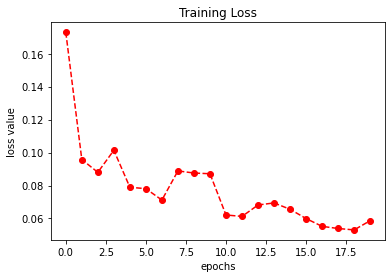

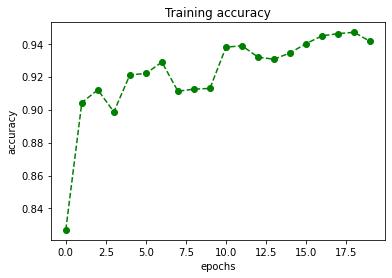

In [11]:
#HOME-MADE ALGORITHM
# Neural Network (NN) parameters
epochs=20
learning_rate=0.26
verbose= True
print_every_k=5

# Initialization of the NN
NN1 = MLP([reshape,100, 1])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
accuracy_test_MLP_home_made=MLP.accuracy(y_hat,y_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

## 2.2)The Super Vector Machine (SVM) of Scikit learn
We also wanted to test the Support Vector Machines on our data. Similarly to the MLP, we have some parameters to optimize so we did a cross validation.

In [12]:
#SVM example
print("******SVM********")
clf = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)
train_score=clf.score(x_train, y_train)
print("clf.score(x_train, y_train)",train_score)
test_score=clf.score(x_test, y_test)
print("clf.score(x_test, y_test)",test_score)

******SVM********
clf.score(x_train, y_train) 0.9818809318377912
clf.score(x_test, y_test) 0.9418604651162791


In [13]:
#cross validation

C=[0.1,0.5,1,2,5,10,40]
kernel=['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
gamma=[2, 'auto', 'scale']

test1=[4000, 'rbf','auto']
test2=[4000,'rbf', 0.002]
test3=[1000, 'sigmoid', 'auto']
test4=[1, 'linear','auto']
test5=[4000, 'rbf', 0.001]

T=[test1,test2, test3,test4, test5]
random.shuffle(T)
k=len(T)
n=len(x_train)
step=int(n/k)


scores=[]
for i in range(k) :
    print("********iterations", i+1, T[i], "***********")
    x_train_i=[]
    y_train_i=[]
    for j in range(k):
        if j!=i : #all th efolders exepct the i
            for r in x_train[j*step:(j+1)*step] :
                x_train_i.append(r)
            for r in y_train[j*step:(j+1)*step] :
                y_train_i.append(r)
    x_test_i=x_train[i*step:(i+1)*step]
    y_test_i=y_train[i*step:(i+1)*step]
    print("len x_train: ", len(x_train_i))
    print("len x_test: ", len(x_test_i))
    clf = svm.SVC(kernel=T[i][1], C=T[i][0], gamma=T[i][2]).fit(x_train_i, y_train_i)
    train_score=clf.score(x_train_i, y_train_i)
    print("clf.score(x_train, y_train)",train_score)
    test_score=clf.score(x_test_i, y_test_i)
    print("clf.score(x_test, y_test)",test_score)
    scores.append(test_score)
    #scor = cross_val_score(clf, x_train, y_train, cv=5)
    #print("Validation Kernel scores: ", scor)
    #print("%0.2f accuracy with a standard deviation of %0.2f" % (scor.mean(), scor.std()))
    #result = open("save_results", "a") 
    #result.write ("cross validation SVM ; Parameters : " + str(T[i])   + ", train score:  " + str(train_score) + ", accuracy test=" + str(test_score) + "\n")
    #result.close()

best=scores.index(max(scores))

print("************best parameters for SVM **************")
print(best+1 ,T[best], "test scores: " , scores[best])


print("**********results on the test dataset with the selected estimator******")
svm_best = svm.SVC(kernel=T[best][1], C=T[best][0], gamma=T[best][2])
clf_svm_best=svm_best.fit(x_train, y_train)
train_score=clf_svm_best.score(x_train, y_train)
print("clf.score(x_train, y_train)",train_score)
test_score_svm_best=clf_svm_best.score(x_test, y_test)
print("clf.score(x_test, y_test)",test_score_svm_best)


********iterations 1 [4000, 'rbf', 0.001] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9330453563714903
********iterations 2 [4000, 'rbf', 'auto'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9244060475161987
********iterations 3 [4000, 'rbf', 0.002] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 1.0
clf.score(x_test, y_test) 0.9438444924406048
********iterations 4 [1, 'linear', 'auto'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 0.9859611231101512
clf.score(x_test, y_test) 0.9395248380129589
********iterations 5 [1000, 'sigmoid', 'auto'] ***********
len x_train:  1852
len x_test:  463
clf.score(x_train, y_train) 0.974622030237581
clf.score(x_test, y_test) 0.937365010799136
************best parameters for SVM **************
3 [4000, 'rbf', 0.002] test scores:  0.9438444924406048
**********results on th

At the end of the cross validation, the selected candidate is : 
C=4000, kernel= 'rbf’ and gamma=0.002
With this estimator, we attempted to have 100% accuracy on the train dataset and  95% accuracy on the test dataset.
When we did the validation on the training set we had : 94% accuracy  in average with a standard deviation of 1%, which means the model is quite reliable.


# 2.4) Time to select the final estimator

In order to make a choice between all the classifiers,and to make sure the estimator is efficient and robust, we test them on several datasets to see the average score and the variance.

In [14]:
print("*******For the self made MLP classifier*********** ")
print("accuracy on the test dataset : " , accuracy_test_MLP_home_made )
print("*******For the MLP classifier*********** ")
score_mlp = cross_val_score(mlp_best, x_train, y_train, cv=5)
print(" Validation MLP scores: ", score_mlp)
print("%0.2f accuracy with a standard deviation of %0.2f" % (score_mlp.mean(), score_mlp.std()))
print("Score on the test dataset : " , test_score_mlp_best)
print("*******For the SVM classifier*********** ")
score_svm = cross_val_score(svm_best, x_train, y_train, cv=5)
print("Validation SVM scores: ", score_svm)
print("%0.2f accuracy with a standard deviation of %0.2f" % (score_svm.mean(), score_svm.std()))
print("Score on the test dataset : " , test_score_svm_best)

*******For the self made MLP classifier*********** 
accuracy on the test dataset :  [0.90697674]
*******For the MLP classifier*********** 
 Validation MLP scores:  [0.92456897 0.92887931 0.94612069 0.93736501 0.94600432]
0.94 accuracy with a standard deviation of 0.01
Score on the test dataset :  0.9457364341085271
*******For the SVM classifier*********** 
Validation SVM scores:  [0.94181034 0.92887931 0.93965517 0.92656587 0.94600432]
0.94 accuracy with a standard deviation of 0.01
Score on the test dataset :  0.9573643410852714


## Conclusion 
For two estimators with the same accuracy, the best one is the more reliable one, which is the one with the least deviation on the validation score.
Here , we have the same deviation but a better accuracy for the SVM (95,7%). Hence we would choose this model.
